In [85]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score

from collections import defaultdict
from sklearn.utils import resample
from tabulate import tabulate

In [72]:
import seaborn as sns

## 1. Bais in performance

load file

In [247]:
# file: prediction on test
result_dir='../../isic_results/'
# run_type = 'disease/densenet-all/'
run_type = 'disease/resnet/'
model_name = run_type.split('/')[1]

prediction_file = 'predictions.test.csv'
df_pred_test = pd.read_csv(result_dir+run_type+prediction_file)
print(len(df_pred_test))
# df_pred_test.head(10)

4621


In [248]:
# file (df) - metadata on test
meta_dir = '../datafiles/'
meta_file = 'ISIC_2019_metadata-clean-split.csv'
df_meta = pd.read_csv(meta_dir+meta_file)
df_meta_test = df_meta[df_meta['split'] == 'test']
print(len(df_meta_test))
# df_meta_test.head(10)


4621


combine two df

In [249]:
df = pd.concat([df_pred_test.reset_index(drop=True), df_meta_test.reset_index(drop=True)],axis=1)
df.shape

(4621, 45)

In [250]:
df.columns

Index(['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5',
       'class_6', 'class_7', 'class_8', 'logit_0', 'logit_1', 'logit_2',
       'logit_3', 'logit_4', 'logit_5', 'logit_6', 'logit_7', 'logit_8',
       'target_0', 'target_1', 'target_2', 'target_3', 'target_4', 'target_5',
       'target_6', 'target_7', 'target_8', 'isic_id', 'age_approx',
       'anatom_site_general', 'lesion_id', 'sex', 'MEL', 'NV', 'BCC', 'AK',
       'BKL', 'DF', 'VASC', 'SCC', 'UNK', 'path', 'disease', 'split',
       'path_preproc'],
      dtype='object')

### performance for each disease:

AUROC of MEL: 	0.84
AUROC of NV: 	0.90
AUROC of BCC: 	0.92
AUROC of AK: 	0.89
AUROC of BKL: 	0.83
AUROC of DF: 	0.87
AUROC of VASC: 	0.94
AUROC of SCC: 	0.87


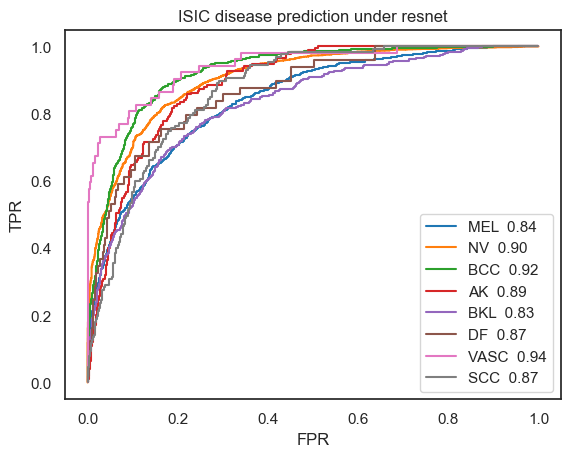

In [251]:
disease_labels = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']
num_classes = len(disease_labels)

plt.figure()
sns.set_theme(style="white", palette=None)

for i in range(num_classes):
    true_labels = df['target_'+str(i)]
    pred_labels = df['class_'+str(i)]
    if true_labels.sum() == 0:
        continue
    fpr, tpr, thres = roc_curve(true_labels, pred_labels)
    
    
    plt.plot(fpr,tpr,label = disease_labels[i]+'  {:.2f}'.format(roc_auc_score(true_labels, pred_labels)))
    print('AUROC of {}: \t{:.2f}'.format(disease_labels[i],roc_auc_score(true_labels, pred_labels)))

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ISIC disease prediction under {}'.format(model_name))
plt.show()

### ROC for disease and gender

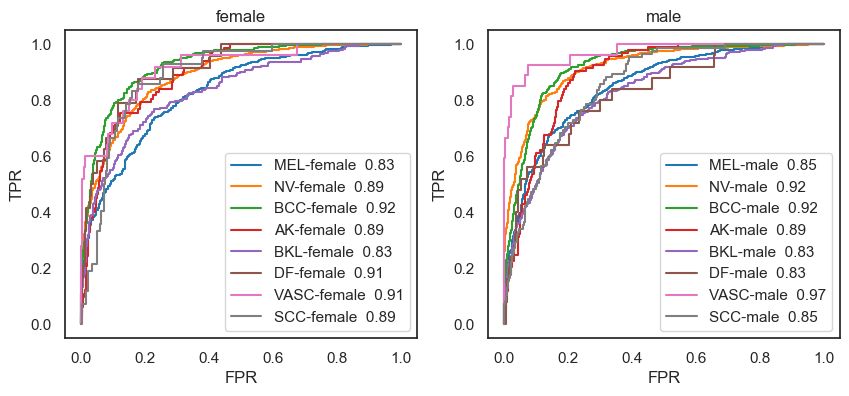

In [252]:
disease_labels = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']
genders = ['female','male']
num_classes = len(disease_labels)

fig, axes = plt.subplots(1,2,figsize=(10,4))
sns.set_theme(style="white", palette=None)

for i in range(num_classes):
    for j,each_g in enumerate(genders):
        true_labels = df[df['sex']==each_g]['target_'+str(i)]
        pred_labels = df[df['sex']==each_g]['class_'+str(i)]
        
        if true_labels.sum() == 0:
            continue
            
        fpr, tpr, thres = roc_curve(true_labels, pred_labels)

        

        axes[j].plot(fpr,tpr,label = disease_labels[i]+'-'+each_g+'  {:.2f}'.format(roc_auc_score(true_labels, pred_labels)))
#         print('AUROC of {}: \t{:.2f}'.format(disease_labels[i],roc_auc_score(true_labels, pred_labels)))


for j in range(len(genders)):
    axes[j].set_title(genders[j])
    axes[j].legend()
    axes[j].set_xlabel('FPR')
    axes[j].set_ylabel('TPR')
    


plt.legend()
plt.show()

### auc, TPR, FPR in tables for sensitive attributes subgroups

In [253]:
def get_boostrap_ci_for_full_experiment(
    targets: np.ndarray,
    predictions: np.ndarray,
    sex: np.ndarray,
    n_bootstrap: int = 2000,
    level: float = 0.95,
):
    """
    Get all CIs for FPR/TPR/Youden/AUC per subgroup for a global threshold with target fpr of 0.2
    """
    n_samples = targets.shape[0]

    all_fpr, all_tpr, all_roc_auc, all_youden = (
        defaultdict(list),
        defaultdict(list),
        defaultdict(list),
        defaultdict(list),
    )

    for b in tqdm(range(n_bootstrap + 1)):

        # GET BOOTSTRAP SAMPLE
        # At the first iteration, store the sample estimate without resampling.
        idx = (
            resample(np.arange(n_samples), stratify=targets)
            if b > 0
            else np.arange(n_samples)
        )
        
#         print(len(idx))

        sample_target, sample_pred = targets[idx], predictions[idx]
        sample_sex = sex[idx]

        fpr, tpr, thres = roc_curve(sample_target, sample_pred)
        all_roc_auc["all"].append(auc(fpr, tpr))

        # Computing global threshold
        idx_target_fpr_threshold = np.argmin(np.abs(fpr - target_fpr))
        op = thres[idx_target_fpr_threshold]
        all_fpr["all"].append(fpr[idx_target_fpr_threshold])
        all_tpr["all"].append(tpr[idx_target_fpr_threshold])
        all_youden["all"].append(
            (tpr[idx_target_fpr_threshold] - fpr[idx_target_fpr_threshold])
        )

    
        # Getting sex subgroup results
        for s in [male, female]:
            targets_s, preds_s = (
                sample_target[sample_sex == s],
                sample_pred[sample_sex == s],
            )
            all_roc_auc[s].append(roc_auc_score(targets_s, preds_s))
            all_fpr[s].append(1 - recall_score(targets_s, preds_s >= op, pos_label=0))
            all_tpr[s].append(recall_score(targets_s, preds_s >= op, pos_label=1))
            all_youden[s].append(all_tpr[s][-1] - all_fpr[s][-1])

    def _get_pretty_string_from_bootstrap_estimates(boostrap_estimates: np.ndarray):
        alpha = (1 - level) / 2
        return f"{boostrap_estimates[0]: .3f} ({np.quantile(boostrap_estimates[1:], alpha):.3f}-{np.quantile(boostrap_estimates[1:], 1 - alpha):.3f})"

    return {
        "AUC": {
            male: _get_pretty_string_from_bootstrap_estimates(all_roc_auc[male]),
            female: _get_pretty_string_from_bootstrap_estimates(all_roc_auc[female]),
            "all": _get_pretty_string_from_bootstrap_estimates(all_roc_auc["all"]),
        },
        "TPR": {
            male: _get_pretty_string_from_bootstrap_estimates(all_tpr[male]),
            female: _get_pretty_string_from_bootstrap_estimates(all_tpr[female]),
            "all": _get_pretty_string_from_bootstrap_estimates(all_tpr["all"]),
        },
        "FPR": {
            male: _get_pretty_string_from_bootstrap_estimates(all_fpr[male]),
            female: _get_pretty_string_from_bootstrap_estimates(all_fpr[female]),
            "all": _get_pretty_string_from_bootstrap_estimates(all_fpr["all"]),
        },
        "Youden's Index": {
            male: _get_pretty_string_from_bootstrap_estimates(all_youden[male]),
            female: _get_pretty_string_from_bootstrap_estimates(all_youden[female]),
            "all": _get_pretty_string_from_bootstrap_estimates(all_youden["all"]),
        },
    }


In [254]:
target_fpr = 0.2

# PARAMETERS FOR CI
n_bootstrap = 100
ci_level = 0.95

male = "male"
female = "female"

# GET RESULTS
for i in range(num_classes):
    true_labels = df['target_'+str(i)]
    pred_labels = df['class_'+str(i)]
    if true_labels.sum()==0:
        continue
    
    sex = df.sex.values

    results = get_boostrap_ci_for_full_experiment(
            targets=true_labels,
            predictions=pred_labels,
            sex=sex,
            n_bootstrap=n_bootstrap,
        )

    columns_as_in_manuscript = [female, male, "all"]
    res_df = pd.DataFrame.from_dict(results, orient="index")[
            columns_as_in_manuscript
        ]
    print(
            f"\nResults for: {disease_labels[i].upper()} ({ci_level * 100:.0f}%-CI with {n_bootstrap} bootstrap samples)"
        )
    print(tabulate(res_df, headers=res_df.columns))

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:01<00:00, 86.19it/s]



Results for: MEL (95%-CI with 100 bootstrap samples)
                female               male                 all
--------------  -------------------  -------------------  -------------------
AUC             0.831 (0.809-0.854)  0.850 (0.832-0.866)  0.841 (0.825-0.854)
TPR             0.668 (0.616-0.720)  0.738 (0.698-0.774)  0.706 (0.669-0.734)
FPR             0.194 (0.180-0.207)  0.206 (0.194-0.217)  0.201 (0.199-0.200)
Youden's Index  0.474 (0.420-0.529)  0.531 (0.491-0.573)  0.506 (0.469-0.533)


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:01<00:00, 82.08it/s]



Results for: NV (95%-CI with 100 bootstrap samples)
                female               male                 all
--------------  -------------------  -------------------  -------------------
AUC             0.888 (0.874-0.899)  0.917 (0.907-0.926)  0.905 (0.895-0.911)
TPR             0.843 (0.810-0.861)  0.838 (0.814-0.859)  0.841 (0.812-0.857)
FPR             0.241 (0.222-0.257)  0.168 (0.158-0.184)  0.199 (0.199-0.201)
Youden's Index  0.602 (0.571-0.634)  0.671 (0.638-0.694)  0.642 (0.612-0.657)


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:01<00:00, 88.84it/s]



Results for: BCC (95%-CI with 100 bootstrap samples)
                female               male                 all
--------------  -------------------  -------------------  -------------------
AUC             0.924 (0.907-0.937)  0.920 (0.901-0.930)  0.922 (0.911-0.930)
TPR             0.867 (0.824-0.908)  0.917 (0.887-0.941)  0.898 (0.871-0.913)
FPR             0.187 (0.171-0.195)  0.215 (0.204-0.227)  0.202 (0.199-0.201)
Youden's Index  0.681 (0.631-0.721)  0.702 (0.666-0.726)  0.696 (0.671-0.713)


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:01<00:00, 86.56it/s]



Results for: AK (95%-CI with 100 bootstrap samples)
                female               male                 all
--------------  -------------------  -------------------  -------------------
AUC             0.892 (0.863-0.914)  0.889 (0.858-0.914)  0.889 (0.871-0.906)
TPR             0.793 (0.701-0.864)  0.849 (0.789-0.918)  0.823 (0.766-0.877)
FPR             0.196 (0.187-0.210)  0.199 (0.192-0.211)  0.198 (0.200-0.201)
Youden's Index  0.596 (0.501-0.668)  0.650 (0.582-0.718)  0.625 (0.566-0.677)


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:01<00:00, 90.29it/s]



Results for: BKL (95%-CI with 100 bootstrap samples)
                female               male                 all
--------------  -------------------  -------------------  -------------------
AUC             0.835 (0.806-0.864)  0.827 (0.806-0.857)  0.831 (0.813-0.850)
TPR             0.691 (0.639-0.753)  0.717 (0.675-0.789)  0.706 (0.674-0.756)
FPR             0.175 (0.164-0.187)  0.223 (0.212-0.232)  0.200 (0.200-0.200)
Youden's Index  0.516 (0.463-0.577)  0.494 (0.453-0.566)  0.505 (0.474-0.556)


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:01<00:00, 93.11it/s]



Results for: DF (95%-CI with 100 bootstrap samples)
                female               male                 all
--------------  -------------------  -------------------  -------------------
AUC             0.908 (0.846-0.956)  0.830 (0.761-0.890)  0.869 (0.824-0.910)
TPR             0.875 (0.702-1.000)  0.640 (0.479-0.833)  0.755 (0.622-0.868)
FPR             0.225 (0.202-0.224)  0.203 (0.179-0.199)  0.213 (0.199-0.201)
Youden's Index  0.650 (0.486-0.785)  0.437 (0.291-0.643)  0.542 (0.422-0.668)


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:01<00:00, 87.84it/s]



Results for: VASC (95%-CI with 100 bootstrap samples)
                female               male                 all
--------------  -------------------  -------------------  -------------------
AUC             0.914 (0.853-0.964)  0.970 (0.943-0.993)  0.941 (0.905-0.974)
TPR             0.840 (0.659-0.962)  0.963 (0.864-1.000)  0.904 (0.798-0.981)
FPR             0.190 (0.171-0.195)  0.222 (0.204-0.225)  0.207 (0.199-0.200)
Youden's Index  0.650 (0.484-0.774)  0.741 (0.652-0.795)  0.697 (0.598-0.781)


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:01<00:00, 90.95it/s]


Results for: SCC (95%-CI with 100 bootstrap samples)
                female               male                 all
--------------  -------------------  -------------------  -------------------
AUC             0.889 (0.849-0.916)  0.854 (0.826-0.878)  0.869 (0.846-0.888)
TPR             0.857 (0.716-0.940)  0.718 (0.624-0.818)  0.764 (0.685-0.827)
FPR             0.186 (0.174-0.195)  0.217 (0.204-0.224)  0.202 (0.199-0.201)
Youden's Index  0.672 (0.536-0.754)  0.500 (0.408-0.599)  0.562 (0.485-0.627)


## 2. Bais in latent space

In latent representation:  
Get embeddings:

In [255]:
num_features=1024 if 'densenet' in run_type else 512
embs = pd.read_csv(result_dir+run_type + '/embeddings.test.csv')
embeds = np.array(embs.iloc[:,0:num_features])
n, m = embeds.shape
print(embeds.shape)

(4621, 512)


### PCA

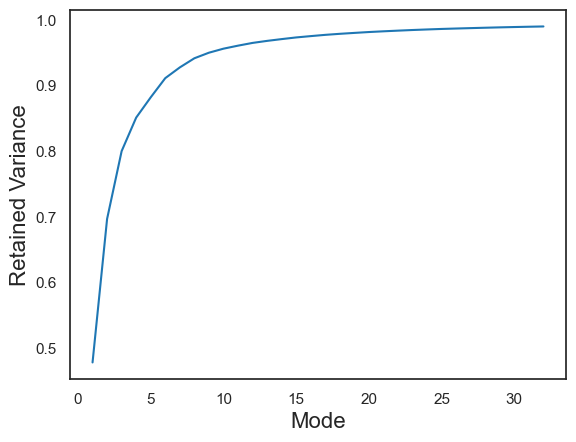

(4621, 32)


In [256]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=0.99, whiten=False)
embeds_pca = pca.fit_transform(embeds)

mu = pca.mean_
U = pca.components_.T
D = pca.singular_values_**2 / (n - 1)
exp_var = pca.explained_variance_ratio_

fig, ax = plt.subplots()
ax.plot(range(1,len(exp_var)+1),np.cumsum(exp_var))
ax.set_xlabel('Mode', fontsize=16)
ax.set_ylabel('Retained Variance', fontsize=16)
plt.show()

df['PCA Mode 1'] = embeds_pca[:,0]
df['PCA Mode 2'] = embeds_pca[:,1]
df['PCA Mode 3'] = embeds_pca[:,2]
df['PCA Mode 4'] = embeds_pca[:,3]

print(embeds_pca.shape)

### t-SNE

In [257]:
from sklearn.manifold import TSNE
import time
time_start = time.time()
embeds_tsne = TSNE(n_components=2, init='random', learning_rate='auto').fit_transform(embeds)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 17.132662057876587 seconds


In [258]:
df['t-SNE Dimension 1'] = embeds_tsne[:,0]
df['t-SNE Dimension 2'] = embeds_tsne[:,1]

### choose disease that you'd like analysis

In [259]:
print(disease_labels)
df.groupby('disease').count()['class_0']

['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']


disease
AK       175
BCC      664
BKL      445
DF        49
MEL      824
NV      2285
SCC      127
VASC      52
Name: class_0, dtype: int64

In [260]:
chose_disease = 1

In [261]:
# df['Other'] = df[disease_labels[chose_disease]].apply(lambda x: 0 if x==1 else 1)
df['disease_sim'] = df['disease'].apply(lambda x: x if x == disease_labels[chose_disease] else 'Other')

### sampling

In [262]:
n_samples = 2000

df_male = df[df['sex'] == 'male'].sample(n=n_samples)
df_female = df[df['sex'] == 'female'].sample(n=n_samples)

sample_test_sex = pd.concat([df_male, df_female])

### ploting

In [263]:
alpha = 0.5
style = 'o'
markersize = 40
kind = 'scatter'
rasterized_scatter = True

#### t-SNE

In [264]:
method = 'tsne'
xdat = 't-SNE Dimension 1'
ydat = 't-SNE Dimension 2'

In [265]:
[disease_labels[chose_disease], 'Other'],

(['NV', 'Other'],)

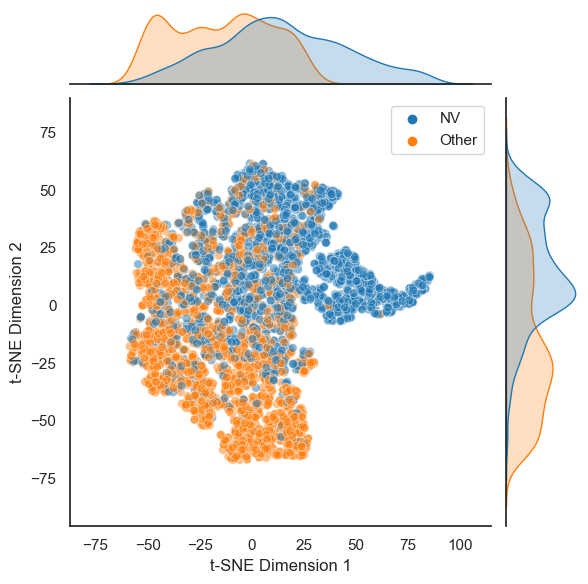

In [266]:
label = 'disease_sim'
sns.set_theme(style="white", palette=None)
fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, marker=style, 
                    s=markersize, hue_order=[disease_labels[chose_disease], 'Other'], 
                    data=sample_test_sex, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
# plt.savefig(method + '-' + model + '-disease.' + out_format, bbox_inches='tight', dpi=300)
xlim = fig.ax_joint.get_xlim()
ylim = fig.ax_joint.get_ylim()

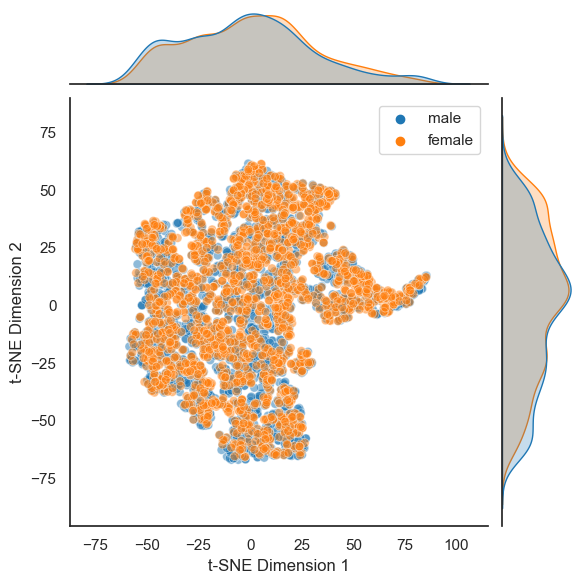

In [267]:
label = 'sex'
sns.set_theme(style="white", palette=None)
fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, 
                    xlim=xlim, ylim=ylim, marker=style, s=markersize, 
                    hue_order=['male', 'female'], data=sample_test_sex, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
# plt.savefig(method + '-' + model + '-sex.' + out_format, bbox_inches='tight', dpi=300)

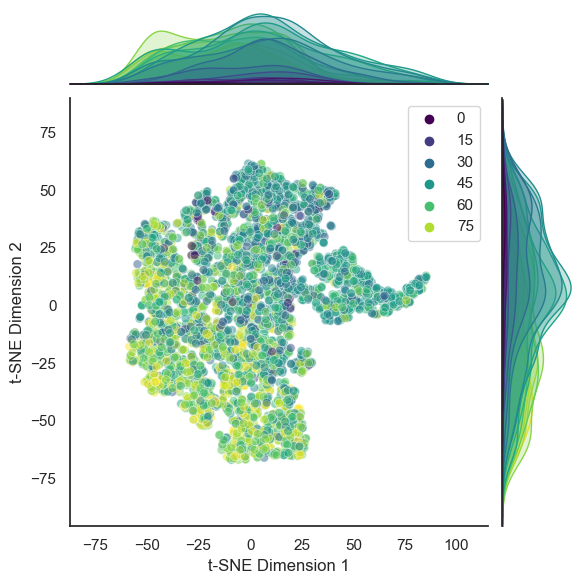

In [268]:
label = 'age_approx'
sns.set_theme(style="white", palette=None)
fig = sns.jointplot(x=xdat, y=ydat, hue=label, alpha=alpha, xlim=xlim, ylim=ylim, 
                    marker=style, s=markersize, palette='viridis', data=sample_test_sex,
                    joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
# plt.savefig(method + '-' + model + '-age.' + out_format, bbox_inches='tight', dpi=300)

#### PCA

In [269]:
method = 'pca'
xdat = 'PCA Mode 1'
ydat = 'PCA Mode 2'

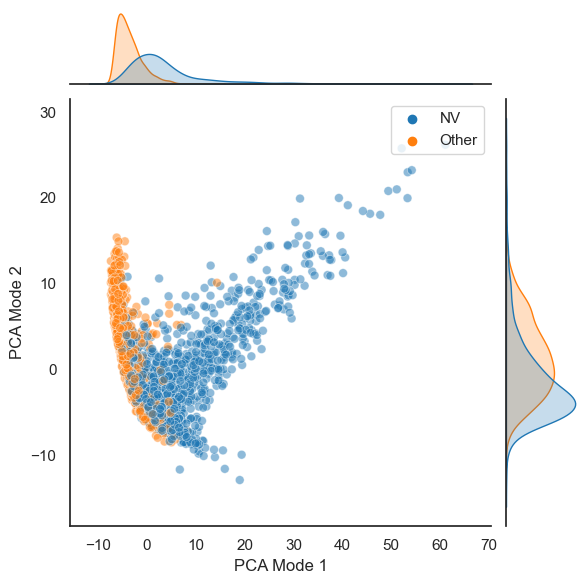

In [270]:
label = 'disease_sim'
sns.set_theme(style="white", palette=None)
fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, 
                    marker=style, s=markersize, hue_order=[disease_labels[chose_disease], 'Other'], 
                    data=sample_test_sex, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
# plt.savefig(method + '-' + model + '-disease-mode-1+2.' + out_format, bbox_inches='tight', dpi=300)
xlim = fig.ax_joint.get_xlim()
ylim = fig.ax_joint.get_ylim()

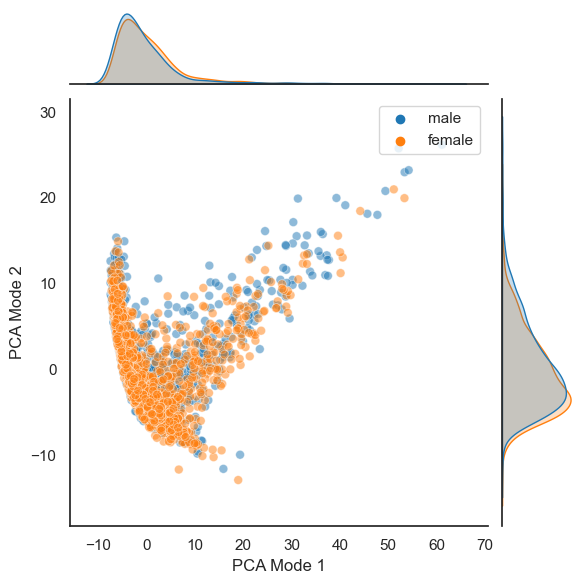

In [271]:
label = 'sex'
sns.set_theme(style="white", palette=None)
fig = sns.jointplot(x=xdat, y=ydat, hue=label,
                    kind=kind, alpha=alpha, xlim=xlim, ylim=ylim, 
                    marker=style, s=markersize, hue_order=['male', 'female'], data=sample_test_sex, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
# plt.savefig(method + '-' + model + '-sex-mode-1+2.' + out_format, bbox_inches='tight', dpi=300)

In [272]:
method = 'pca'
xdat = 'PCA Mode 3'
ydat = 'PCA Mode 4'

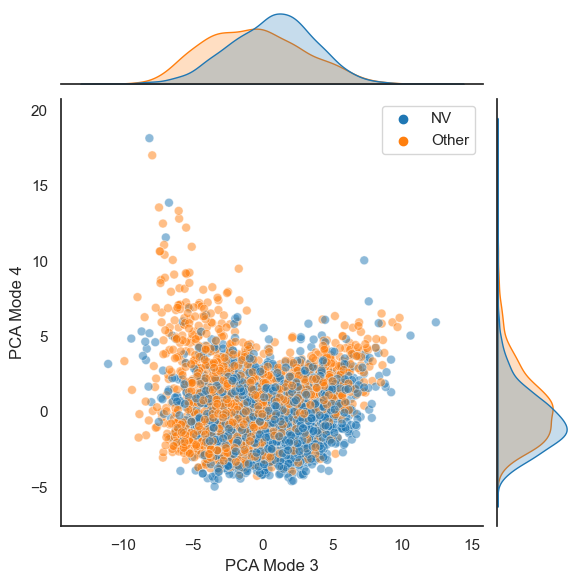

In [273]:
label = 'disease_sim'
sns.set_theme(style="white", palette=None)
fig = sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, 
                    marker=style, s=markersize, hue_order=[disease_labels[chose_disease], 'Other'], 
                    data=sample_test_sex, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
# plt.savefig(method + '-' + model + '-disease-mode-1+2.' + out_format, bbox_inches='tight', dpi=300)
xlim = fig.ax_joint.get_xlim()
ylim = fig.ax_joint.get_ylim()

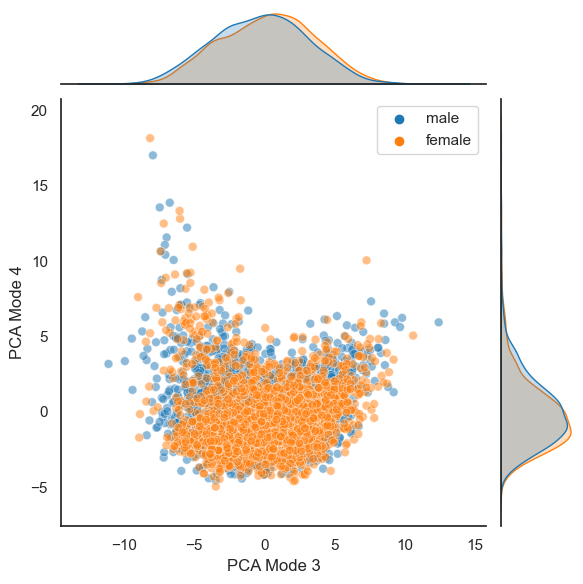

In [274]:
label = 'sex'
sns.set_theme(style="white", palette=None)
fig = sns.jointplot(x=xdat, y=ydat, hue=label,
                    kind=kind, alpha=alpha, xlim=xlim, ylim=ylim, 
                    marker=style, s=markersize, hue_order=['male', 'female'], data=sample_test_sex, joint_kws=dict(rasterized=rasterized_scatter))
fig.ax_joint.legend(loc='upper right')
# plt.savefig(method + '-' + model + '-sex-mode-1+2.' + out_format, bbox_inches='tight', dpi=300)